In [1]:
# BERT Text Classification using Keras

# py37TF2 - home-imac

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

In [2]:

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [3]:
data = pd.read_csv('./data_political_compass/political_compass_datasets.csv')

In [4]:
data.head()

,Unnamed: 0,text,label
0,0,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,center
1,1,They told Reuter correspondents in Asian capit...,center
2,2,But some exporters said that while the conflic...,center
3,3,The U.S. Has said it will impose 300 mln dlrs ...,center
4,4,Unofficial Japanese estimates put the impact o...,center


In [5]:
print('File has {} rows and {} columns'.format(data.shape[0],data.shape[1]))

File has 1548 rows and 3 columns


In [6]:
# Select required columns
data = data[['text', 'label']]

In [7]:
data.head()

,text,label
0,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,center
1,They told Reuter correspondents in Asian capit...,center
2,But some exporters said that while the conflic...,center
3,The U.S. Has said it will impose 300 mln dlrs ...,center
4,Unofficial Japanese estimates put the impact o...,center


In [8]:
# Remove rows, where the label is present only ones (can't be split)
data = data.groupby('label').filter(lambda x : len(x) > 1)
#data = data.groupby('Product').filter(lambda x : len(x) > 1)

In [9]:
data.head()

,text,label
0,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,center
1,They told Reuter correspondents in Asian capit...,center
2,But some exporters said that while the conflic...,center
3,The U.S. Has said it will impose 300 mln dlrs ...,center
4,Unofficial Japanese estimates put the impact o...,center


In [10]:
# shaffle datasets
data = data.sample(frac=1).reset_index(drop=True)
data

,text,label
0,"Well, as of this month, there's now a contextu...",lean_left
1,What his happening to his support among Republ...,lean_left
2,The simultaneous foreign and domestic crises w...,left
3,"Well, I think the main reason I wanted to set ...",lean_left
4,(Yasuyoshi Chiba/AFP/Getty Images)\nNepal\nCov...,left
...,...,...
1543,"Outside the windows, aides were rushing to pre...",left
1544,(Michael Dantas/AFP/Getty Images)\nKenya\nEarl...,left
1545,Unofficial Japanese estimates put the impact o...,center
1546,"Well, I think it's interesting that despite th...",lean_left


In [11]:
data=data.dropna()                                                           # Drop NaN valuues, if any
data=data.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values
data = shuffle(data)                                                         # Shuffle the dataset
print('Available labels: ',data.label.unique())                              # Print all the unique labels in the dataset
data['text']=data['text'].map(preprocess_sentence)                           # Clean the text column using preprocess_sentence function defined above

Available labels:  ['left' 'lean_left' 'center' 'right' 'lean_right']


In [12]:

print('File has {} rows and {} columns'.format(data.shape[0],data.shape[1]))
data.head()

File has 1548 rows and 2 columns


,text,label
1470,program plagued problems program mark annivers...,left
827,target two facilities belonged state owned oil...,lean_left
178,yeah guy blonde raises eyebrows tilts head bit...,lean_left
530,importantly think would given opposition legit...,lean_left
300,last year bought million worth american flags ...,lean_left


In [13]:
num_classes=len(data.label.unique())
num_classes

5

In [14]:

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:

sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


In [16]:
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =30,pad_to_max_length = True,
return_attention_mask = True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/kimkwangil/opt/anaconda3/envs/py38pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:

tokenized_sequence

{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [18]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [19]:
data['gt'] = data['label'].map({'left':0,'lean_left':1, 'center':2,'lean_right':3, 'right':4})
data.head()

,text,label,gt
1470,program plagued problems program mark annivers...,left,0
827,target two facilities belonged state owned oil...,lean_left,1
178,yeah guy blonde raises eyebrows tilts head bit...,lean_left,1
530,importantly think would given opposition legit...,lean_left,1
300,last year bought million worth american flags ...,lean_left,1


In [20]:

sentences=data['text']
labels=data['gt']
len(sentences),len(labels)

(1548, 1548)

# 문장을 숫자변환 예

- Original Sentence: Let's learn deep learning!

- Tokenized Sentence: ['Let', "'", 's', 'learn', 'deep', 'learning', '!']

- Adding [CLS] and [SEP] Tokens: ['[CLS]', 'Let', "'", 's', 'learn', 'deep', 'learning', '!', '[SEP]']

- Padding: ['[CLS]', 'Let', "'", 's', 'learn', 'deep', 'learning', '!', '[SEP]', '[PAD]']

- Converting to IDs: [101, 2421, 112, 188, 3858, 1996, 3776, 106, 102, 0]

In [21]:
input_ids=[] # 입력데디터 리스트 선언
attention_masks=[] # 앞뒤 정보를 비교하여 마스크 예측하기 위한 리스트 선언

for sent in sentences: # 문장하나씩 가져와서 인풋, 마스스크를 추가
    # 문장을 숫자로 바꾼다. 짧은 문장은 패딩처리하고, 토큰화 한다.
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/Users/kimkwangil/opt/anaconda3/envs/py38pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
input_ids

array([[  101,  2565, 17808, ...,     0,     0,     0],
       [  101,  4539,  2048, ...,     0,     0,     0],
       [  101,  3398,  3124, ...,     0,     0,     0],
       ...,
       [  101,  3809,  3947, ...,     0,     0,     0],
       [  101, 21411, 18218, ...,     0,     0,     0],
       [  101, 19647,  2375, ...,     0,     0,     0]])

In [23]:
attention_masks

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [24]:
labels

array([0, 1, 1, ..., 4, 1, 1])

In [25]:
len(input_ids),len(attention_masks),len(labels)

(1548, 1548, 1548)

In [26]:

print('Preparing the pickle file.....')

pickle_inp_path='./data_pc/bert_inp.pkl'
pickle_mask_path='./data_pc/bert_mask.pkl'
pickle_label_path='./data_pc/bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./data_pc/bert_inp.pkl ./data_pc/bert_mask.pkl ./data_pc/bert_label.pkl


In [27]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (1548, 64) Attention mask shape (1548, 64) Input label shape (1548,)


In [28]:
input_ids # 입력문장

array([[  101,  2565, 17808, ...,     0,     0,     0],
       [  101,  4539,  2048, ...,     0,     0,     0],
       [  101,  3398,  3124, ...,     0,     0,     0],
       ...,
       [  101,  3809,  3947, ...,     0,     0,     0],
       [  101, 21411, 18218, ...,     0,     0,     0],
       [  101, 19647,  2375, ...,     0,     0,     0]])

In [29]:
attention_masks # 마스크처리된 데이터

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [30]:
labels # 문장당 레이블(5 가지 척도)

array([0, 1, 1, ..., 4, 1, 1])

In [31]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (1238, 64) Val input shape (310, 64)
Train label shape (1238,) Val label shape (310,)
Train attention mask shape (1238, 64) Val attention mask shape (310, 64)


In [32]:
# 예측에 사용하는 데이터

# input_ids : val_inp    --> 입력문장
# val_mask --> 마스크처리된 단어

In [33]:
val_inp

array([[  101,  3389,  8376, ...,     0,     0,     0],
       [  101,  2502,  4119, ...,     0,     0,     0],
       [  101,  7928, 10187, ...,     0,     0,     0],
       ...,
       [  101, 10622,  2742, ...,     0,     0,     0],
       [  101,  2738,  6698, ...,     0,     0,     0],
       [  101,  2773,  2613, ...,     0,     0,     0]])

In [34]:
val_inp.shape

(310, 64)

In [35]:
val_label

array([1, 1, 0, 4, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 4, 4, 1, 4, 0, 1, 4,
       0, 1, 4, 1, 1, 1, 0, 0, 0, 4, 0, 0, 1, 1, 1, 4, 1, 1, 4, 0, 1, 0,
       0, 0, 1, 4, 1, 4, 1, 1, 3, 1, 0, 2, 1, 1, 2, 1, 4, 1, 2, 1, 1, 0,
       1, 2, 1, 0, 1, 1, 0, 0, 0, 4, 1, 0, 4, 1, 2, 4, 1, 1, 1, 1, 3, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 4, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 2, 1, 1, 3, 1, 0, 4, 0, 0, 4, 1, 0, 1, 1, 0, 0,
       2, 0, 0, 1, 4, 0, 0, 1, 0, 4, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 4, 0,
       1, 3, 1, 0, 2, 1, 0, 1, 0, 2, 1, 1, 4, 1, 1, 1, 0, 0, 1, 4, 1, 0,
       0, 4, 0, 4, 1, 0, 1, 1, 4, 1, 4, 1, 0, 4, 1, 1, 0, 1, 0, 4, 0, 0,
       4, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 4, 1, 0, 1,
       1, 4, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 4, 1,
       3, 0, 0, 0, 1, 0, 1, 1, 4, 1, 1, 0, 1, 2, 0, 4, 3, 2, 2, 1, 0, 3,
       1, 4, 4, 1, 4, 4, 2, 0, 0, 4, 0, 4, 1, 4, 4, 0, 1, 1, 0, 1, 2, 0,
       0, 1, 4, 2, 0, 0, 0, 0, 1, 1, 1, 1, 4, 0, 0,

In [36]:
val_label.shape

(310,)

In [37]:
val_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [38]:
val_mask.shape

(310, 64)

In [39]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [28]:

history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=40,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
39/39 [==============================] - 182s 4s/step - loss: 1.2654 - accuracy: 0.4830 - val_loss: 1.1255 - 

In [29]:
%load_ext tensorboard

In [32]:
log_dir='tensorboard_data/bert_model'
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 7805), started 0:28:50 ago. (Use '!kill 7805' to kill it.)

In [40]:

model_save_path='./models/bert_model.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=5)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)
print('preds:', preds)
print(type(preds))
preds = preds['logits']
print('preds_:', preds)
# import numpy as np
# pred_labels = np.argmax(preds)
pred_labels = preds.argmax(axis=1)
print('pred_labels', pred_labels)
print('val_label', val_label)

f1 = f1_score(val_label,pred_labels, average='micro')
print('F1 score',f1)
print('Classification Report')
target_names = ['left', 'lean_left', 'center', 'lean_right', 'right']
print(classification_report(val_label,pred_labels,target_names=target_names))

print('Training and saving built model.....')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
preds: TFSequenceClassifierOutput(loss=None, logits=array([[-0.93124175,  2.8134732 , -0.75567746, -0.29249525, -0.79274

In [47]:
# sentence label : center
# sent_input = """The U.S. Has said it will impose 300 mln dlrs of tariffs on
#   imports of Japanese electronics goods on April 17, in
#   retaliation for Japan's alleged failure to stick to a pact not
#   to sell semiconductors on world markets at below cost."""

# sentnece label : lean_left

sent_input = """One Metropolitan Police officer who was beaten and tased during the riot, Michael Fanone, has advocated for the release of his body camera video and repeatedly criticized Republicans who've tried to downplay the violence during the insurrection."""



# 문장을 숫자로 바꾼다. 짧은 문장은 패딩처리하고, 토큰화 한다.
bert_inp=bert_tokenizer.encode_plus(sent_input,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
input_ids=bert_inp['input_ids']
attention_masks= bert_inp['attention_mask']

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [48]:
bert_inp

{'input_ids': [101, 2028, 4956, 2610, 2961, 2040, 2001, 7854, 1998, 11937, 6924, 2076, 1996, 11421, 1010, 2745, 5470, 5643, 1010, 2038, 11886, 2005, 1996, 2713, 1997, 2010, 2303, 4950, 2678, 1998, 8385, 6367, 10643, 2040, 1005, 2310, 2699, 2000, 2091, 13068, 1996, 4808, 2076, 1996, 27860, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [49]:
input_ids

array([  101,  2028,  4956,  2610,  2961,  2040,  2001,  7854,  1998,
       11937,  6924,  2076,  1996, 11421,  1010,  2745,  5470,  5643,
        1010,  2038, 11886,  2005,  1996,  2713,  1997,  2010,  2303,
        4950,  2678,  1998,  8385,  6367, 10643,  2040,  1005,  2310,
        2699,  2000,  2091, 13068,  1996,  4808,  2076,  1996, 27860,
        1012,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [50]:
attention_masks

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
# val_inp : input_ids
# val_mask : attention_masks

preds = trained_model.predict([input_ids,attention_masks],batch_size=32)
preds = preds['logits'] # 시그모이드함수 적용하여 데이터의 결과를 두 그룹으로 분류해본다. 0 or 1
print("prieds'logit':", preds)
pred_labels = preds.argmax(axis=1)
print('pred_labels', pred_labels)

prieds'logit': [[-5.24842553e-02  1.82543397e+00 -8.46833169e-01 -8.44775960e-02
  -8.40243936e-01]
 [-2.85867602e-01  1.35519576e+00 -5.65001607e-01 -9.64295641e-02
  -5.01159430e-01]
 [-1.01913393e+00  5.30431330e-01  3.40114504e-01  3.43670785e-01
  -2.79483706e-01]
 [-9.07833874e-01  2.50474215e-01  5.33834457e-01  3.16946536e-01
  -3.03752035e-01]
 [ 9.60471705e-02  1.96115315e+00 -7.30817020e-01 -5.89179575e-01
  -8.70315433e-01]
 [-5.36861479e-01  1.08087969e+00 -3.28828782e-01  5.79277091e-02
  -3.00352991e-01]
 [-3.36623937e-01  2.44781446e+00 -9.46398914e-01 -5.31451285e-01
  -5.83607852e-01]
 [-7.04245627e-01  1.97341704e+00 -1.73900828e-01 -1.10629730e-01
  -6.96813941e-01]
 [-6.08947933e-01  1.49358463e+00 -2.57193029e-01 -4.33791466e-02
  -5.57025433e-01]
 [ 4.46318507e-01  2.23049116e+00 -1.29007757e+00 -6.60751998e-01
  -1.01215112e+00]
 [-6.57604873e-01  2.24270090e-01  5.43115199e-01 -1.47137314e-03
  -6.15595460e-01]
 [ 1.16619982e-01  6.91773653e-01 -2.20935345e-01 

In [52]:
type(pred_labels)

numpy.ndarray

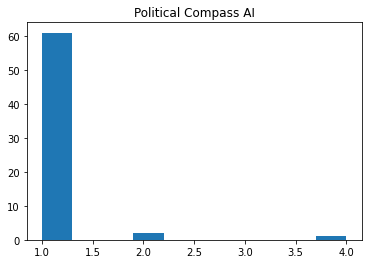

In [85]:
plt.hist(pred_labels)

plt.title("Political Compass AI")


plt.show()

In [89]:
result = np.bincount(pred_labels)
result = np.argmax(result)
result

1

In [95]:
def get_political_compass(result):
    if result == 0:
        print('Left')
        result = 'Left'
    elif result == 1:
        print('Lean_Left')
        result = 'Lean_Left'
    elif result == 2:
        print('Center')
        result = 'Center'
    elif reulst == 3:
        print('Lean_Right')
        result = 'Lean_Right'
    else:
        print('Right')
        result = 'Right'
    return result

In [96]:
Final_Result = get_political_compass(result)

Lean_Left
